In [ ]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras. layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [ ]:
file_path = 'dataset'
name_class = os.listdir(file_path)
print(name_class, "\nTotal Class",len(name_class))


['Acinetobacter.baumanii', 'Actinomyces.israeli', 'Bacteroides.fragilis', 'Bifidobacterium.spp', 'Candida.albicans', 'Clostridium.perfringens', 'Enterococcus.faecalis', 'Enterococcus.faecium', 'Escherichia.coli', 'Fusobacterium', 'Lactobacillus.casei', 'Lactobacillus.crispatus', 'Lactobacillus.delbrueckii', 'Lactobacillus.gasseri', 'Lactobacillus.jehnsenii', 'Lactobacillus.johnsonii', 'Lactobacillus.paracasei', 'Lactobacillus.plantarum', 'Lactobacillus.reuteri', 'Lactobacillus.rhamnosus', 'Lactobacillus.salivarius', 'Listeria.monocytogenes', 'Micrococcus.spp', 'Neisseria.gonorrhoeae', 'Porfyromonas.gingivalis', 'Propionibacterium.acnes', 'Proteus', 'Pseudomonas.aeruginosa', 'Staphylococcus.aureus', 'Staphylococcus.epidermidis', 'Staphylococcus.saprophiticus', 'Streptococcus.agalactiae', 'Veionella'] 
Total Class 33


In [ ]:
filepaths = list(glob.glob(file_path+'/**/*.*'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(10)

,Filepath,Label
0,dataset\Lactobacillus.rhamnosus\Lactobacillus....,Lactobacillus.rhamnosus
1,dataset\Staphylococcus.saprophiticus\img52.jpg,Staphylococcus.saprophiticus
2,dataset\Fusobacterium\img39.jpg,Fusobacterium
3,dataset\Lactobacillus.casei\Lactobacillus.case...,Lactobacillus.casei
4,dataset\Propionibacterium.acnes\img101.jpg,Propionibacterium.acnes
5,dataset\Staphylococcus.epidermidis\img98.jpg,Staphylococcus.epidermidis
6,dataset\Enterococcus.faecium\img40.jpg,Enterococcus.faecium
7,dataset\Lactobacillus.delbrueckii\img91.jpg,Lactobacillus.delbrueckii
8,dataset\Lactobacillus.johnsonii\img3.jpg,Lactobacillus.johnsonii
9,dataset\Lactobacillus.rhamnosus\img42.jpg,Lactobacillus.rhamnosus


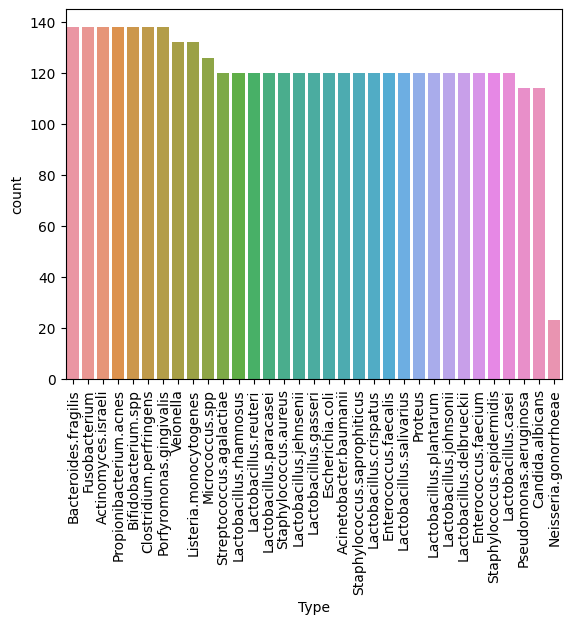

In [ ]:
#balancing
counts = data.Label.value_counts()
sns.barplot(x=counts. index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [ ]:
#balance by deleting extra images (Augmentor API)
#augmentation
#GAN
train, test = train_test_split(data, test_size=0.25, random_state=5)
test

,Filepath,Label
1781,dataset\Enterococcus.faecalis\img79.jpg,Enterococcus.faecalis
3556,dataset\Veionella\img38.jpg,Veionella
3314,dataset\Staphylococcus.aureus\img11.jpg,Staphylococcus.aureus
586,dataset\Staphylococcus.epidermidis\img20.jpg,Staphylococcus.epidermidis
3347,dataset\Lactobacillus.jehnsenii\img64.jpg,Lactobacillus.jehnsenii
...,...,...
3290,dataset\Bifidobacterium.spp\img20.jpg,Bifidobacterium.spp
2588,dataset\Lactobacillus.johnsonii\img42.jpg,Lactobacillus.johnsonii
3810,dataset\Enterococcus.faecalis\img97.jpg,Enterococcus.faecalis
388,dataset\Staphylococcus.epidermidis\img70.jpg,Staphylococcus.epidermidis


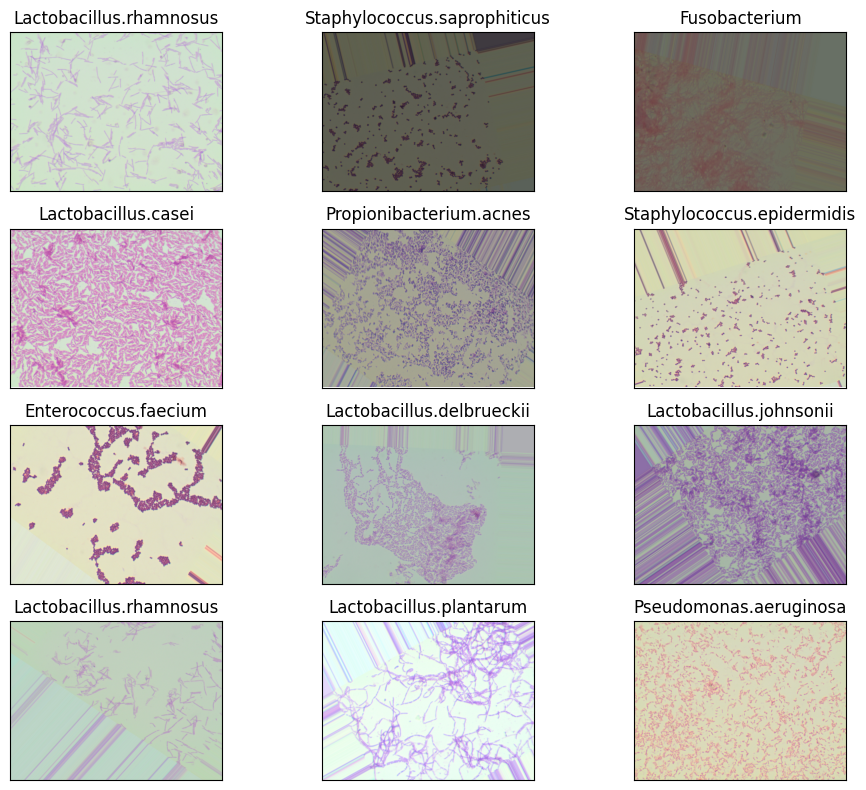

In [ ]:
fig, axes = plt.subplots (nrows=4, ncols=3, figsize=(10,8), subplot_kw={'xticks': [],'yticks':[]})
for i, ax in enumerate (axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator (preprocessing_function=preprocess_input)


In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=1
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=1
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3005 validated image filenames belonging to 33 classes.
Found 1002 validated image filenames belonging to 33 classes.
Found 1002 validated image filenames belonging to 33 classes.


In [ ]:
pretrained_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input
x = Dense (128, activation='relu') (pretrained_model.output)
x = Dense (128, activation='relu') (x)

outputs = Dense (33, activation='softmax')(x)
model = Model(inputs=inputs, outputs = outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
my_callbacks = [EarlyStopping(monitor='val_accuracy',
                            min_delta=0.0001,
                            patience=5,
                            mode='auto')]

In [ ]:
history = model.fit(
    train_gen,
    validation_data = valid_gen,
    epochs=100,
    callbacks=my_callbacks
)

Epoch 1/100
94/94 [==============================] - 161s 2s/step - loss: 1.4838 - accuracy: 0.5817 - val_loss: 0.6569 - val_accuracy: 0.7784
Epoch 2/100
94/94 [==============================] - 158s 2s/step - loss: 0.4156 - accuracy: 0.8622 - val_loss: 0.4779 - val_accuracy: 0.8473
Epoch 3/100
94/94 [==============================] - 157s 2s/step - loss: 0.2230 - accuracy: 0.9341 - val_loss: 0.4257 - val_accuracy: 0.8513
Epoch 4/100
94/94 [==============================] - 157s 2s/step - loss: 0.1406 - accuracy: 0.9587 - val_loss: 0.2925 - val_accuracy: 0.9042
Epoch 5/100
94/94 [==============================] - 158s 2s/step - loss: 0.0968 - accuracy: 0.9750 - val_loss: 0.2373 - val_accuracy: 0.9182
Epoch 6/100
94/94 [==============================] - 159s 2s/step - loss: 0.0745 - accuracy: 0.9817 - val_loss: 0.2292 - val_accuracy: 0.9242
Epoch 7/100
94/94 [==============================] - 156s 2s/step - loss: 0.0505 - accuracy: 0.9894 - val_loss: 0.1755 - val_accuracy: 0.9391
Epoch 

In [ ]:
model.save("model_resnet50.h5")

c:\Users\DECODER\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


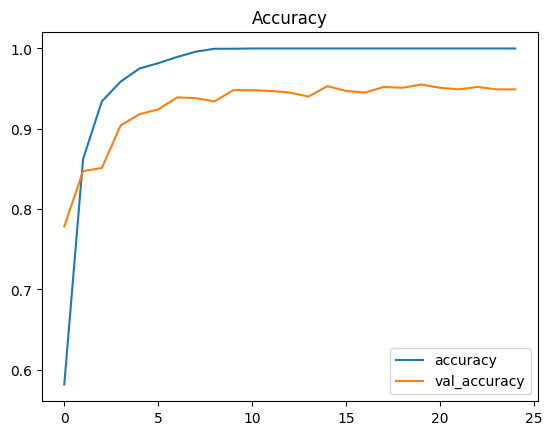

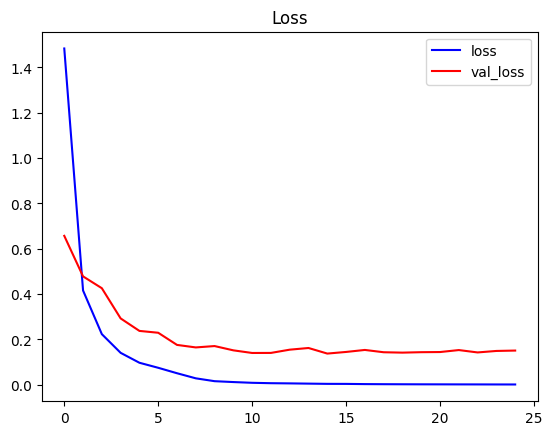

In [ ]:
pd.DataFrame(history.history) [['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history) [['loss', 'val_loss']].plot(color=['blue', 'red'])
plt.title("Loss")
plt.show()

In [ ]:
results = model.evaluate(test_gen, verbose=0)
print("Test Loss: {:.2f}%".format(results[0]*100))
print("Test Accuracy: {:.2f}%".format(results [1] * 100))

Test Loss: 15.06%
Test Accuracy: 94.91%


In [ ]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax (pred, axis=1)

#Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels [k] for k in pred]

32/32 [==============================] - 42s 1s/step


                              precision    recall  f1-score   support

      Acinetobacter.baumanii       0.96      0.93      0.95        28
         Actinomyces.israeli       0.90      0.97      0.94        38
        Bacteroides.fragilis       0.79      0.92      0.85        37
         Bifidobacterium.spp       0.94      0.88      0.91        33
            Candida.albicans       1.00      1.00      1.00        28
     Clostridium.perfringens       1.00      0.97      0.98        33
       Enterococcus.faecalis       0.93      0.93      0.93        30
        Enterococcus.faecium       0.90      1.00      0.95        26
            Escherichia.coli       0.93      0.97      0.95        38
               Fusobacterium       1.00      1.00      1.00        34
         Lactobacillus.casei       0.95      0.91      0.93        23
     Lactobacillus.crispatus       0.95      0.97      0.96        36
   Lactobacillus.delbrueckii       0.94      0.94      0.94        36
       Lactobacillu

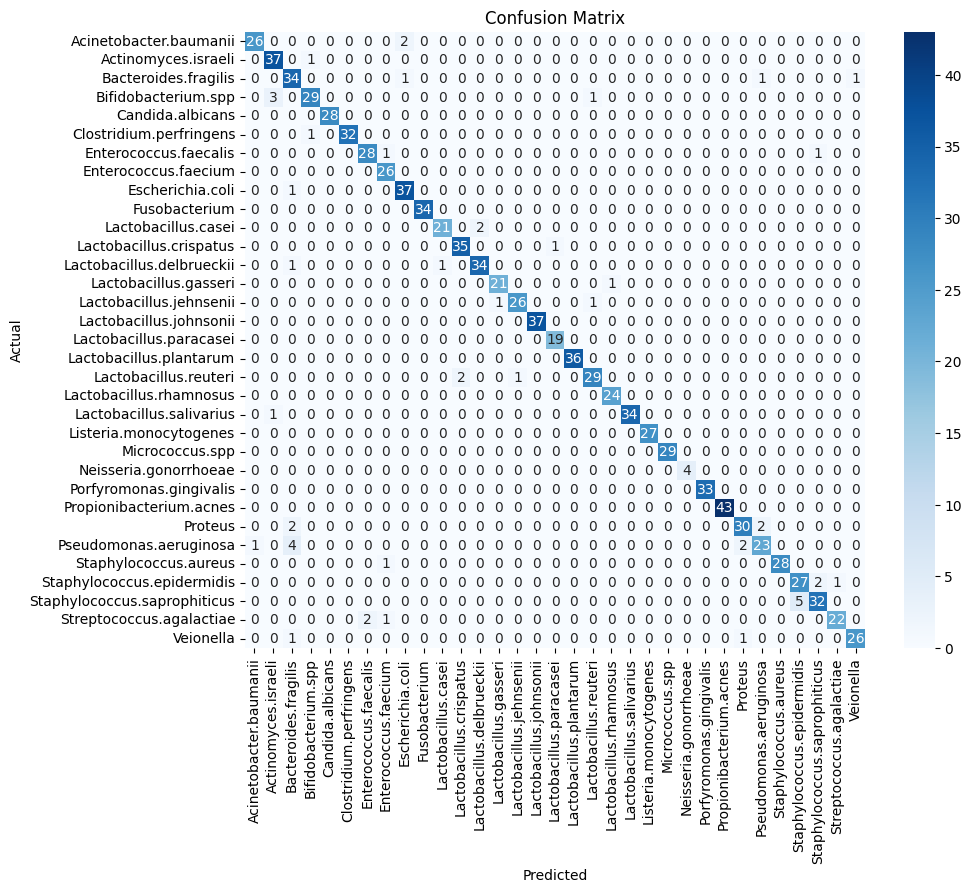

In [ ]:
y_test = list(test.Label)
print(classification_report(y_test,pred))

confusion_mat = confusion_matrix(y_test, pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=name_class, yticklabels=name_class)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




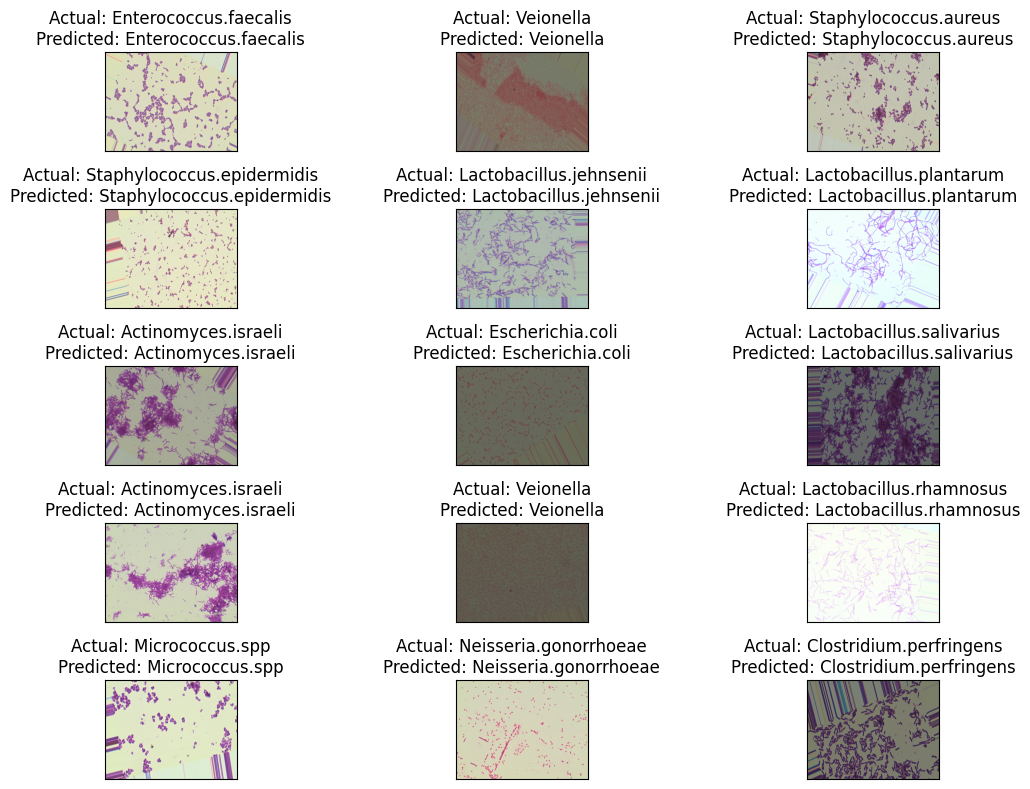

In [ ]:
fig, axes = plt.subplots (nrows=5, ncols=3, figsize=(12, 8),
                          subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate (axes.flat):
    ax.imshow(plt.imread(test. Filepath.iloc[i]))
    ax.set_title(f"Actual: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.imagenet_utils import preprocess_input


loaded_model_imageNet = load_model("model_resnet50.h5")

img_path = 'dataset\Lactobacillus.plantarum\img7.jpg'
img= cv2.imread(img_path)

if img is None:
    raise ValueError("Unable to read the image at the specified path.")

img = cv2.resize(img, (224, 224))

x = np.expand_dims (img, axis=0)
x = preprocess_input(x)
result = model.predict(x)

prediction_array = (result*100).astype('int')
p =list(prediction_array[0])

my_image = imread(img_path)
imshow(my_image)

index= p.index (max(p))
print("Prediction is:", name_class[index])